# ML Diagnostic Engine — Predicting Query Performance

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import warnings
warnings.filterwarnings("ignore")


## 5.1 loading the data 

In [2]:
DATA_PATH = r"C:\Users\pc\data science\SADOP\data\ml_features_clean.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (19995, 11)


,query,query_time,rows_returned,has_sum,has_group_by,has_where,tables_count,query_length,cpu_usage,memory_usage,is_slow
0,SELECT AVG(total_amount)\nFROM (\n SELECT S...,0.641623,1,1,1,0,2,176,0.0,0.746455,0
1,"SELECT u.user_id, t.transaction_date, t.amount...",1.644557,250000,0,0,0,3,183,12.5,1.108117,1
2,SELECT AVG(total_amount)\nFROM (\n SELECT S...,0.650696,1,1,1,0,2,176,0.0,0.763426,0
3,"SELECT u.user_id, COUNT(t.transaction_id) AS t...",0.620023,16520,0,1,1,3,198,0.0,0.764052,0
4,SELECT DISTINCT u.user_id\nFROM user u\nJOIN a...,0.347722,16329,0,0,1,3,150,0.0,0.768193,0


## 5.2 Define Features & Target

In [3]:
FEATURES = [
    "rows_returned",
    "tables_count",
    "query_length",
    "has_sum",
    "has_group_by",
    "has_where",
    "cpu_usage",
    "memory_usage"
]

TARGET = "is_slow"

X = df[FEATURES]
y = df[TARGET]

print("Features:", FEATURES)



Features: ['rows_returned', 'tables_count', 'query_length', 'has_sum', 'has_group_by', 'has_where', 'cpu_usage', 'memory_usage']


## 5.3 Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (15996, 8)
Test size: (3999, 8)


## 5.4 Feature Scaling

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 5.5 Logistic Regression

In [6]:
logreg = LogisticRegression(
    max_iter=5000,
    solver="lbfgs"
)

logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9372343085771443
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2359
           1       0.95      0.89      0.92      1640

    accuracy                           0.94      3999
   macro avg       0.94      0.93      0.93      3999
weighted avg       0.94      0.94      0.94      3999



## 5.6 Confusion Matrix

In [7]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)
conf_matrix

array([[2282,   77],
       [ 174, 1466]])

## 5.7 Random Forest Classifier

In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9477369342335584
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2359
           1       0.94      0.93      0.94      1640

    accuracy                           0.95      3999
   macro avg       0.95      0.94      0.95      3999
weighted avg       0.95      0.95      0.95      3999



## 5.8 Feature Importance

In [9]:
importances = rf.feature_importances_

assert len(importances) == len(FEATURES)

fi_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df


,feature,importance
0,rows_returned,0.377727
2,query_length,0.237174
1,tables_count,0.100816
5,has_where,0.088178
3,has_sum,0.079160
7,memory_usage,0.075617
6,cpu_usage,0.022299
4,has_group_by,0.019028


## 5.9 CONFUSION MATRIX

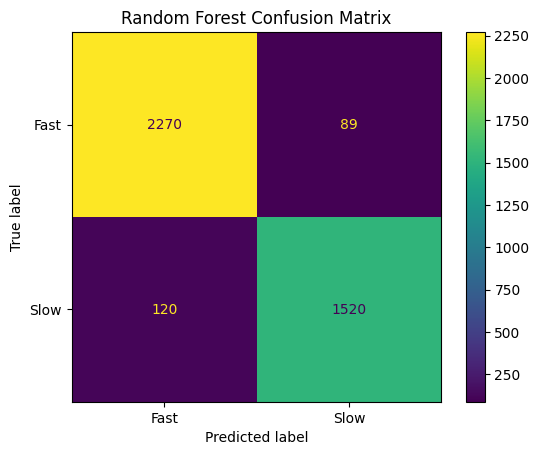

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fast", "Slow"])
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

## 5.10 EXTRACT MISCLASSIFIED QUERIES

In [16]:
import numpy as np

y_pred = rf.predict(X_test)

misclassified_idx = np.where(y_test != y_pred)[0]

misclassified = X_test.iloc[misclassified_idx].copy()
misclassified["true_label"] = y_test.iloc[misclassified_idx]
misclassified["predicted_label"] = y_pred[misclassified_idx]

misclassified

,rows_returned,tables_count,query_length,has_sum,has_group_by,has_where,cpu_usage,memory_usage,true_label,predicted_label
16512,16520,3,151,0,0,1,0.0,1.469007,1,0
19333,16520,3,150,0,0,1,0.0,1.499314,1,0
14394,1,2,176,1,1,0,0.0,1.453288,1,0
18828,16520,3,151,0,0,1,20.0,1.468381,0,1
18801,1,2,176,1,1,0,33.3,1.468381,0,1
...,...,...,...,...,...,...,...,...,...,...
16905,1,2,176,1,1,0,0.0,1.463302,1,0
361,16501,3,195,1,1,0,12.5,1.048514,0,1
12549,25143,2,150,0,1,0,25.0,1.418095,1,0
8626,20000,2,215,1,0,1,0.0,1.376811,1,0


In [13]:
misclassified.groupby("true_label")[["rows_returned", "query_length", "tables_count"]].mean()

,rows_returned,query_length,tables_count
true_label,,,
0,16813.786517,194.404494,2.696629
1,14348.541667,170.533333,2.483333


## 5.9 Save Models

In [14]:
import joblib

MODEL_DIR = r"C:\Users\pc\data science\SADOP\ml\models"
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(rf, f"{MODEL_DIR}/rf_slow_query_model.pkl")
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")

print("✅ Models saved successfully")


✅ Models saved successfully
